# Image denoising using autoencoders

In [1]:
# Load modules 
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Load model
from autoencoder import AutoEncoder

# Load helper functions
from helpers import load_data, preprocess, plot_dataset, plot_training_curves, plot_results

# Sets the seed of the random number generator
np.random.seed(10)
tf.random.set_seed(10)

In [2]:
print(f'Using Tensorflow {tf.__version__}')

Using Tensorflow 2.5.0


### Dataset
We will be using a subset of the NIH Chest X-ray database available on [Kaggle](https://www.kaggle.com/nih-chest-xrays/sample). It consists of 5606 images of size 1024 x 1024 pixels. The metadata can be found in `sample_labels.csv`.

In [3]:
img_path = 'data/nih-cxr-sample/'
metadata_path = 'data/nih-cxr-sample/sample_labels.csv'

img_files = glob(img_path+'*.png') 
assert len(img_files) == 5606

In [4]:
metadata_df = pd.read_csv(metadata_path)

In [5]:
metadata_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [6]:
# Load data

img_size = (64, 64)  # Resize original images
n_samples = 3000  # Load only a subset of the dataset

(x_train, _), (x_test, _) = load_data(img_path, metadata_path, img_size, n_samples)

In [7]:
# Preprocess the training and test data
x_train = preprocess(x_train)
x_test = preprocess(x_test)

# Corrupt images with noise
x_train_noisy = x_train + np.abs(np.random.normal(loc=0.0, scale=0.5, size=x_train.shape))
x_test_noisy = x_test + np.abs(np.random.normal(loc=0.0, scale=0.5, size=x_test.shape))

x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)

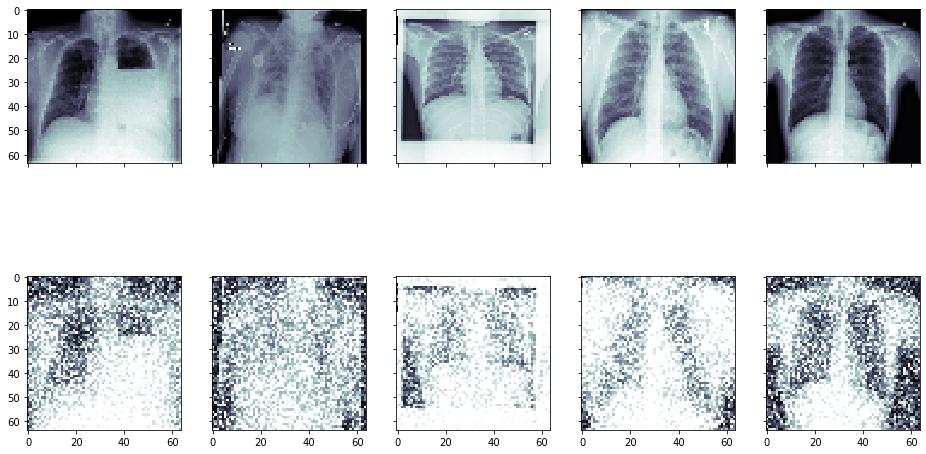

In [8]:
plot_dataset(x_train, x_train_noisy)

### Model
We will be using a convolutional autoencoder described in [(Gondara, 2016)](https://arxiv.org/pdf/1608.04667.pdf).

In [9]:
# Reset Tensorflow graphs
tf.keras.backend.clear_session()

input_shape = (None, img_size[0], img_size[1], 1)
assert x_train.shape[1:] == input_shape[1:]

# Instantiate the model
autoencoder = AutoEncoder(input_shape)

In [10]:
# Build the model
autoencoder.build(input_shape)
autoencoder.call(tf.keras.layers.Input(input_shape[1:]))
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolution2d_1 (Conv2D)     (None, 64, 64, 64)        640       
_________________________________________________________________
maxpooling2d_1 (MaxPooling2D (None, 32, 32, 64)        0         
_________________________________________________________________
convolution2d_2 (Conv2D)     (None, 32, 32, 64)        36928     
_________________________________________________________________
maxpooling2d_2 (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
convolution2d_3 (Conv2D)     (None, 16, 16, 64)        36928     
_________________________________________________________________
upsampling2d_1 (UpSampling2D (None, 32, 32, 64)        0         
_________________________________________________________________
convolution2d_4 (Conv2D)     (None, 32, 32, 64)        

In [11]:
# Define optimizor and loss
lr = 0.0001
optimizer = Adam(learning_rate=lr)
autoencoder.compile(loss='mean_squared_error', optimizer=optimizer)

# Hyperparameters
batch_size = 10
num_epochs = 100

In [12]:
# Train the network
autoencoder_history = autoencoder.fit(x=x_train_noisy, y=x_train, batch_size=batch_size, epochs=num_epochs,
                                      validation_split=0.2, shuffle=True)

Epoch 1/100
192/192 [==============================] - 39s 197ms/step - loss: 0.0204 - val_loss: 0.0075
Epoch 2/100
192/192 [==============================] - 36s 188ms/step - loss: 0.0066 - val_loss: 0.0061
Epoch 3/100
192/192 [==============================] - 38s 200ms/step - loss: 0.0058 - val_loss: 0.0055
Epoch 4/100
192/192 [==============================] - 38s 198ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 5/100
192/192 [==============================] - 38s 199ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 6/100
192/192 [==============================] - 37s 194ms/step - loss: 0.0048 - val_loss: 0.0046
Epoch 7/100
192/192 [==============================] - 37s 191ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 8/100
192/192 [==============================] - 39s 204ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 9/100
192/192 [==============================] - 36s 188ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 10/100
192/192 [==============================] - 36s 187m

192/192 [==============================] - 36s 185ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 78/100
192/192 [==============================] - 35s 185ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 79/100
192/192 [==============================] - 36s 185ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 80/100
192/192 [==============================] - 37s 190ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 81/100
192/192 [==============================] - 36s 187ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 82/100
192/192 [==============================] - 37s 191ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 83/100
192/192 [==============================] - 38s 196ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 84/100
192/192 [==============================] - 36s 187ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 85/100
192/192 [==============================] - 37s 192ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 86/100
192/192 [==============================] - 38s 196ms/st

### Results

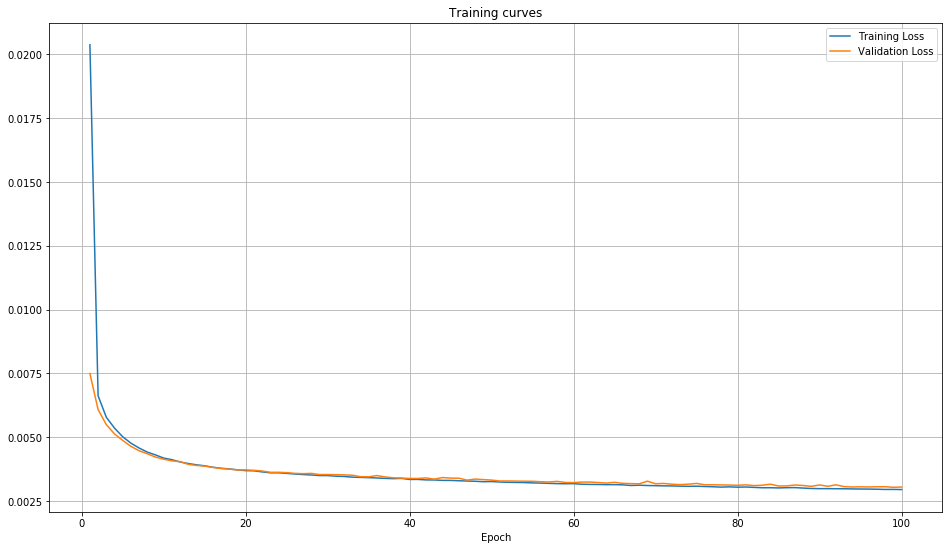

In [13]:
plot_training_curves(autoencoder_history)

In [14]:
autoencoder_pred = autoencoder.predict(x_test_noisy)

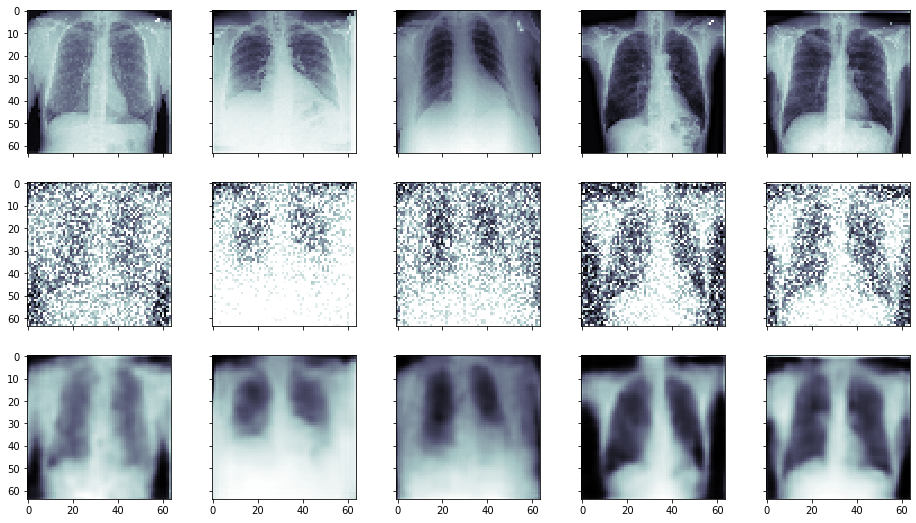

In [15]:
plot_results(x_test, x_test_noisy, autoencoder_pred)